# Group Project Report

Authors: Gabrielle Wong, 

# Introduction 

Due to the rapid industrial development, air pollution has become a major concern. Major metropolitan cities, such as Beijing, suffer from this difficulty. Particulate Matter 2.5 (PM2.5) are tiny particles or droplets in the air that are carcinogenic and causes respiratory disease (Zhao et al.). In order to explore the pattern of Beijing PM2.5 concentration, this study will focus on the question: is PM2.5 concentration in Beijing seasonal? The *Beijing PM2.5 Data Data Set* will be used to answer this question. The dataset contains the hourly data of PM2.5 concentration of the US Embassy in Beijing and the meteorological data is collected from the Beijing Capital International Airport. This data set includes data on the temperature, dew point, pressure, wind conditions, and weather conditions in Beijing from 2010 to 2014. The variable characteristics are either integers or real numbers.


# Exploratory Data Analysis

In [19]:
# load relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(RCurl)
library(dplyr)
library(forcats)

In [20]:
pm2.5_data <- read_csv("https://raw.githubusercontent.com/gbrwg/DSCI100-Group-Project/main/data/beijing_pm2.5_data.csv") %>%
            filter(year == "2010") %>%
            filter(hour == "1") %>%
            na.omit()
head(pm2.5_data)

Parsed with column specification:
cols(
  No = col_double(),
  year = col_double(),
  month = col_double(),
  day = col_double(),
  hour = col_double(),
  pm2.5 = col_double(),
  DEWP = col_double(),
  TEMP = col_double(),
  PRES = col_double(),
  cbwd = col_character(),
  Iws = col_double(),
  Is = col_double(),
  Ir = col_double()
)



No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
26,2010,1,2,1,148,-15,-4,1020,SE,2.68,0,0
50,2010,1,3,1,63,-8,-6,1026,SE,61.69,5,0
74,2010,1,4,1,58,-16,-9,1023,NW,21.90,0,0
98,2010,1,5,1,34,-26,-18,1035,NW,205.60,0,0
122,2010,1,6,1,77,-25,-14,1033,NE,4.02,0,0
146,2010,1,7,1,130,-21,-16,1035,cv,0.45,0,0


The columns in the dataset are:
1. `No`: The row number of the observation

2. `Year`: Year of data in the row

3. `month`: Month of data in this row

4. `day`: day of data in this row

5. `hour`: hour of data in this row

6. `pm2.5`: PM2.5 concentration (ug/m^3)

7. `DEWP`: Dew Point (â„ƒ)

8. `TEMP`: Temperature (â„ƒ)

9. `PRES`: Pressure (hPa)

10. `cbwd`: Combined wind direction

11. `Iws`: Cumulated wind speed (m/s)

12. `ls`: Cumulated hours of snow

13. `lr`: Cumulated hours of rain


From the columns above, 7 out of the 13 columns are quantitative variables that we can use for predictors. From our research, we found that temperature, pressure, dew point, and windspeed can affect PM2.5 concentration (Liang et al; Wang and Ogawa). Hence, we narrowed down our choices for predictors between those variables to perform our exploratory data analysis.

In [21]:
# splitting training and testing data set
set.seed(1)
pm2.5_split <- initial_split(pm2.5_data, prop = 0.75, strata = pm2.5)
pm2.5_train <- training(pm2.5_split)
pm2.5_test <- testing(pm2.5_split)

For the exploratory data analysis, we wanted to plot our potential predictors against our target variable, PM2.5. This is so we can visually observe whether there were any relationships between PM2.5 and the predictors. Thus, we used scatterplots to plot temperature, pressure, dew point, and windspeed against pm2.5.

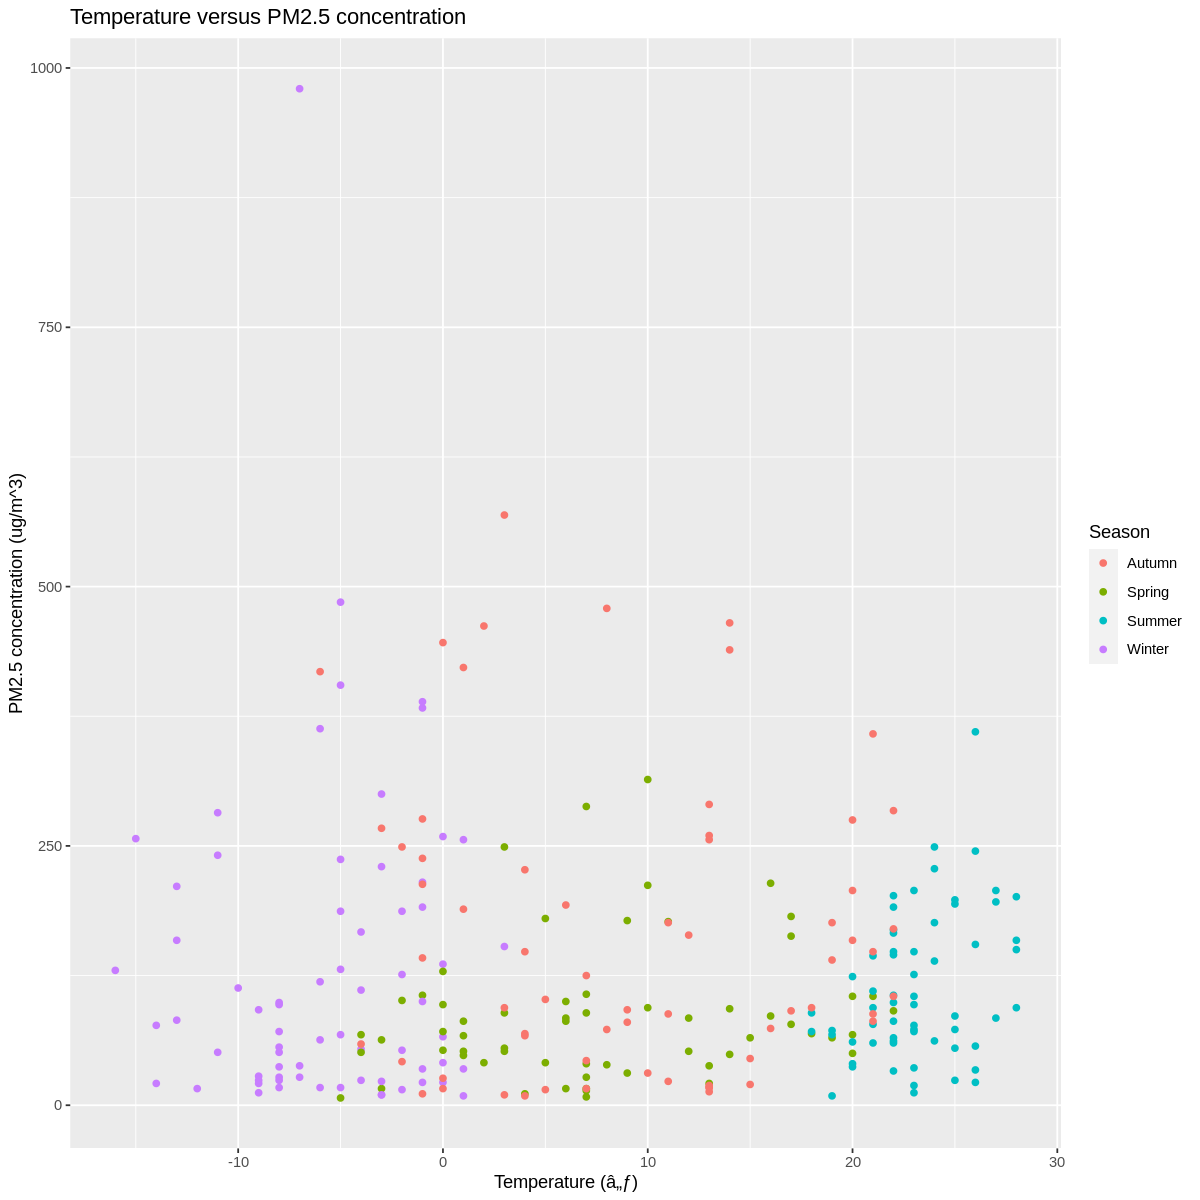

In [34]:
pm2.5_plot_data <- pm2.5_train %>%
        mutate(Season = case_when(month %in% 3:5 ~ 'Spring',
                month %in% 6:8 ~ 'Summer',
                month %in% 9:11 ~ 'Autumn',
                TRUE ~ 'Winter'))
options(repr.plot.width = 10, repr.plot.height = 10)
plotTEMP <- ggplot(pm2.5_plot_data, aes(x = TEMP, y = pm2.5, color = factor(Season))) + 
        geom_point() + 
        labs(x = "Temperature (â„ƒ)", y = "PM2.5 concentration (ug/m^3)", color = "Season") +
        ggtitle("Temperature versus PM2.5 concentration")  

plotTEMP

This graph does not show a clear correlation between PM2.5 concentration and temperature, this suggests that PM2.5 and temperature does not have a relationship or has a very weak correlation. However

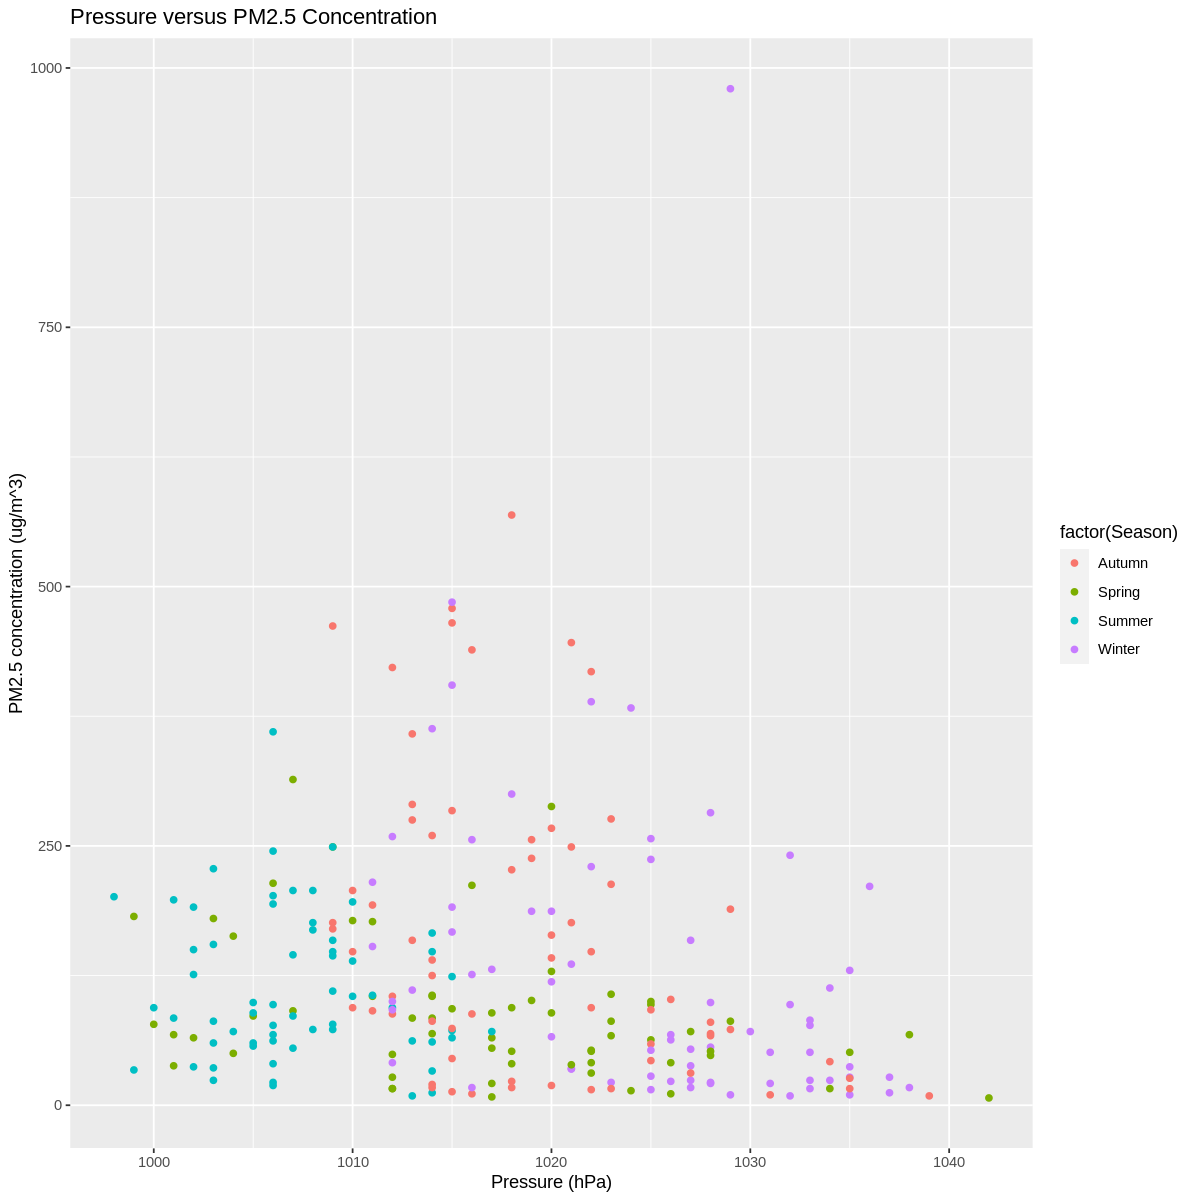

In [35]:
plotPRES <- ggplot(pm2.5_plot_data, aes(x = PRES, y = pm2.5, color = factor(Season))) + 
         geom_point() + 
         labs(x = "Pressure (hPa)", y = "PM2.5 concentration (ug/m^3)") +
        ggtitle("Pressure versus PM2.5 Concentration") 

plotPRES

The plot above suggests negatively correlated linear relationship, as pressure increases PM2.5 concentration decreases. This matches with our research where we found that pressure decreases when PM2.5 concentration increases (Liang et al.).  However, this graph shows a very weak relationship. 

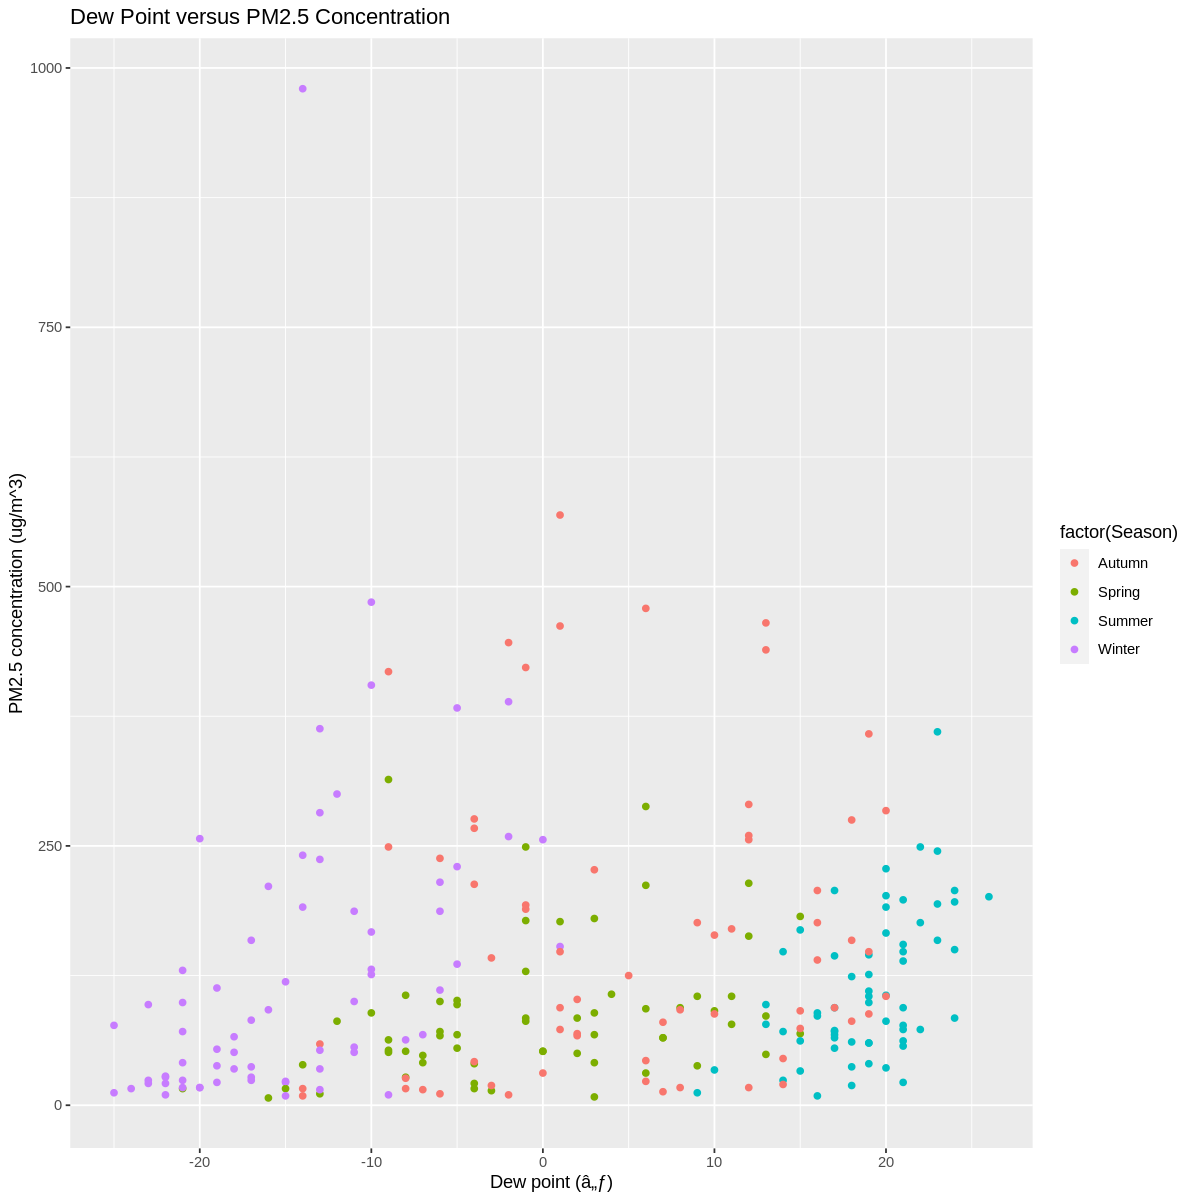

In [36]:
plotDEWP <- ggplot(pm2.5_plot_data, aes(x = DEWP, y = pm2.5, color = factor(Season))) + 
         geom_point() + 
         labs(x = "Dew point (â„ƒ)", y = "PM2.5 concentration (ug/m^3)") +
        ggtitle("Dew Point versus PM2.5 Concentration") 
plotDEWP

This graph above suggests a very weak, positively correlated linear relationship. This indicates that as dew point increases, PM2.5 concentration increases with dew point. This matches with our research where we found that PM2.5 concentration increases with PM2.5 (Liang et al.).

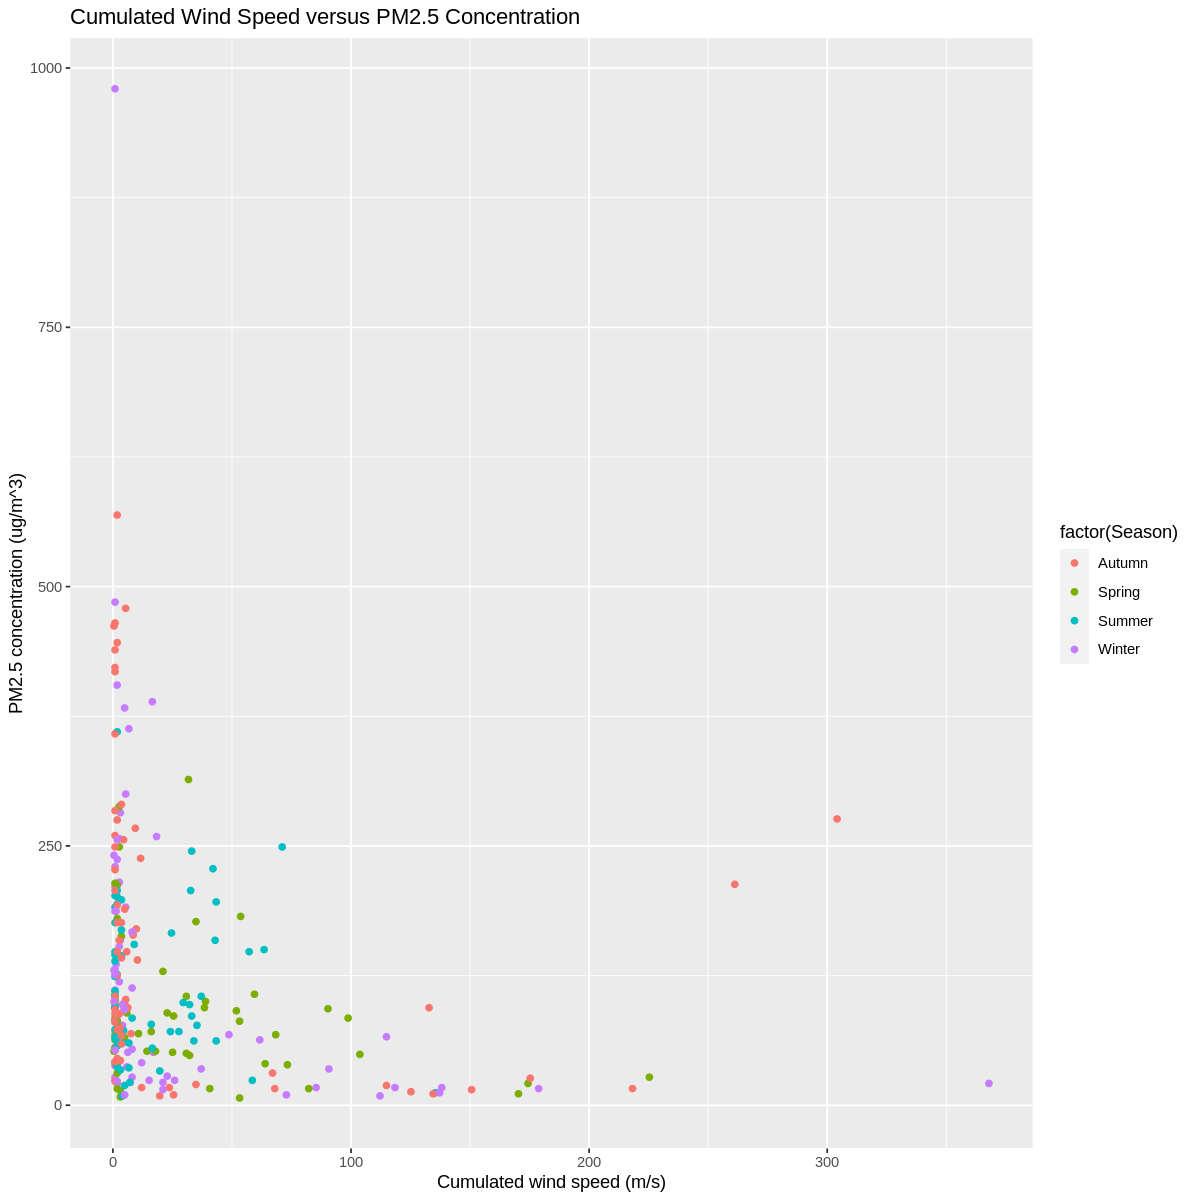

In [37]:
plotlws <- ggplot(pm2.5_plot_data, aes(x = Iws, y = pm2.5, color = factor(Season))) + 
         geom_point() + 
         labs(x = "Cumulated wind speed (m/s)", y = "PM2.5 concentration (ug/m^3)") +
        ggtitle("Cumulated Wind Speed versus PM2.5 Concentration") 

plotlws

This graph seems to suggest a non-linear relationship between PM2.5 concentration and cumulated wind speed. 

Overall, looking at all the plots above, they seem to suggest that temperature has no relationship and dew point and pressure have a weak relationship. To explore this further, we used ggpairs to find the correlation coefficient between the predictors above and PM2.5.

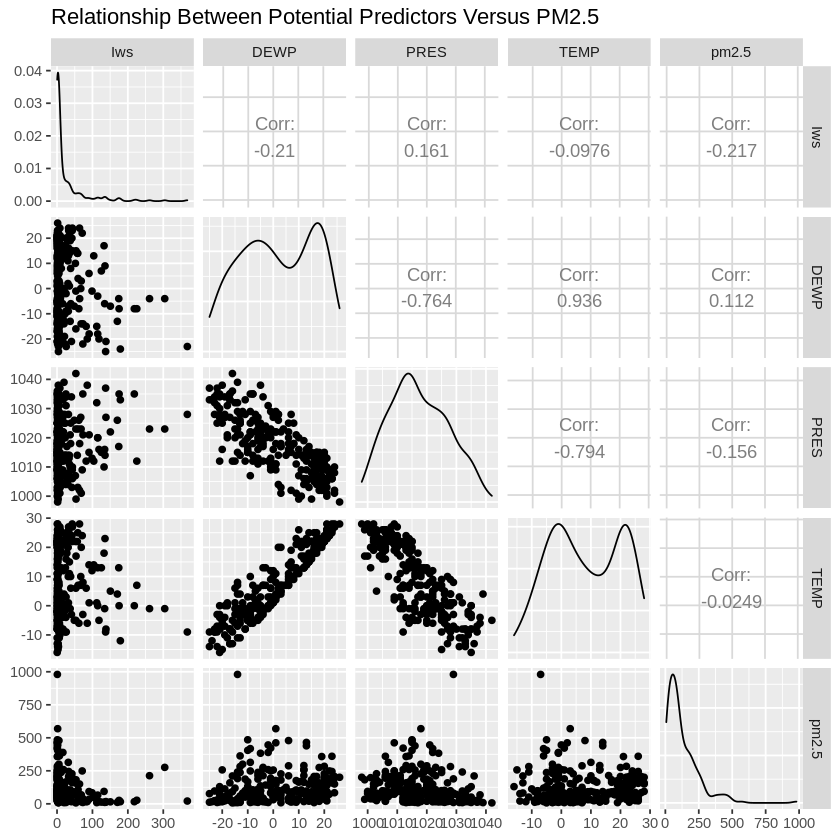

In [8]:
filtered_table <- pm2.5_train %>%
                select(Iws, DEWP, PRES, TEMP, pm2.5)

ggpairs(filtered_table) + ggtitle("Relationship Between Potential Predictors Versus PM2.5")

From the plot above, it seems that temperature would be a very weak predictor given the extremely low correlation coefficient. Interestingly enough, wind speed has the highest correlation coefficient even though the graph did not suggest a relationship. However, since we want to know whether PM2.5 concentration depends on seasonal factors, we will use temperature, dewpoint, cumulated windspeed and pressure to predict PM2.5. 

## Analysis


In our analysis, we will use a K-NN Regression model.

Our predictors are the following: 
- Dewpoint (DEWP)
- Pressure (PRES)
- Cumulated Wind Speed (IWS)
- Temperature (TEMP)

First, we will need to split the data to a training data set and a testing data set, we chose to use 75% of the data as training data because we want to use a larger training data set to train a more accurate model but still getting a fairly accurate evaluation of the performance of the model. 

We will be using K-NN regression to predict the data since our target variable is numerical and we will use cross validation to choose the optimal K. To perform cross-validation we will create a recipe to preprocess our data and standardize the data. It is important for us to standardize the data because each of our predictors have different units. Scaling the data will help ensure that all predictor variables contribute equally to the calculations. We chose to use ten fold cross validation because ten fold cross validation would give us a lower standard error and it would not require too much computational power. 

In [40]:
set.seed(1234)
## Determining the best K 
pm2.5_recipe <- recipe(pm2.5 ~ DEWP + TEMP + PRES + Iws, data = pm2.5_train) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

pm2.5_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
          set_engine("kknn") %>%
          set_mode("regression")

pm2.5_vfold <- vfold_cv(pm2.5_train, v = 10, strata = pm2.5)

gridvals <- tibble(neighbors = seq(1, 200))

pm2.5_multi <- workflow() %>%
        add_recipe(pm2.5_recipe) %>%
        add_model(pm2.5_spec) %>%
        tune_grid(pm2.5_vfold, grid = gridvals) %>%
        collect_metrics() %>%
        filter(.metric == "rmse") 
        
head(pm2.5_multi)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,137.2769,10,13.573391,Model001
2,rmse,standard,114.0770,10,10.424917,Model002
3,rmse,standard,113.2469,10,9.608972,Model003
4,rmse,standard,108.8846,10,9.958334,Model004
5,rmse,standard,109.5537,10,9.577109,Model005
6,rmse,standard,106.3087,10,10.652500,Model006


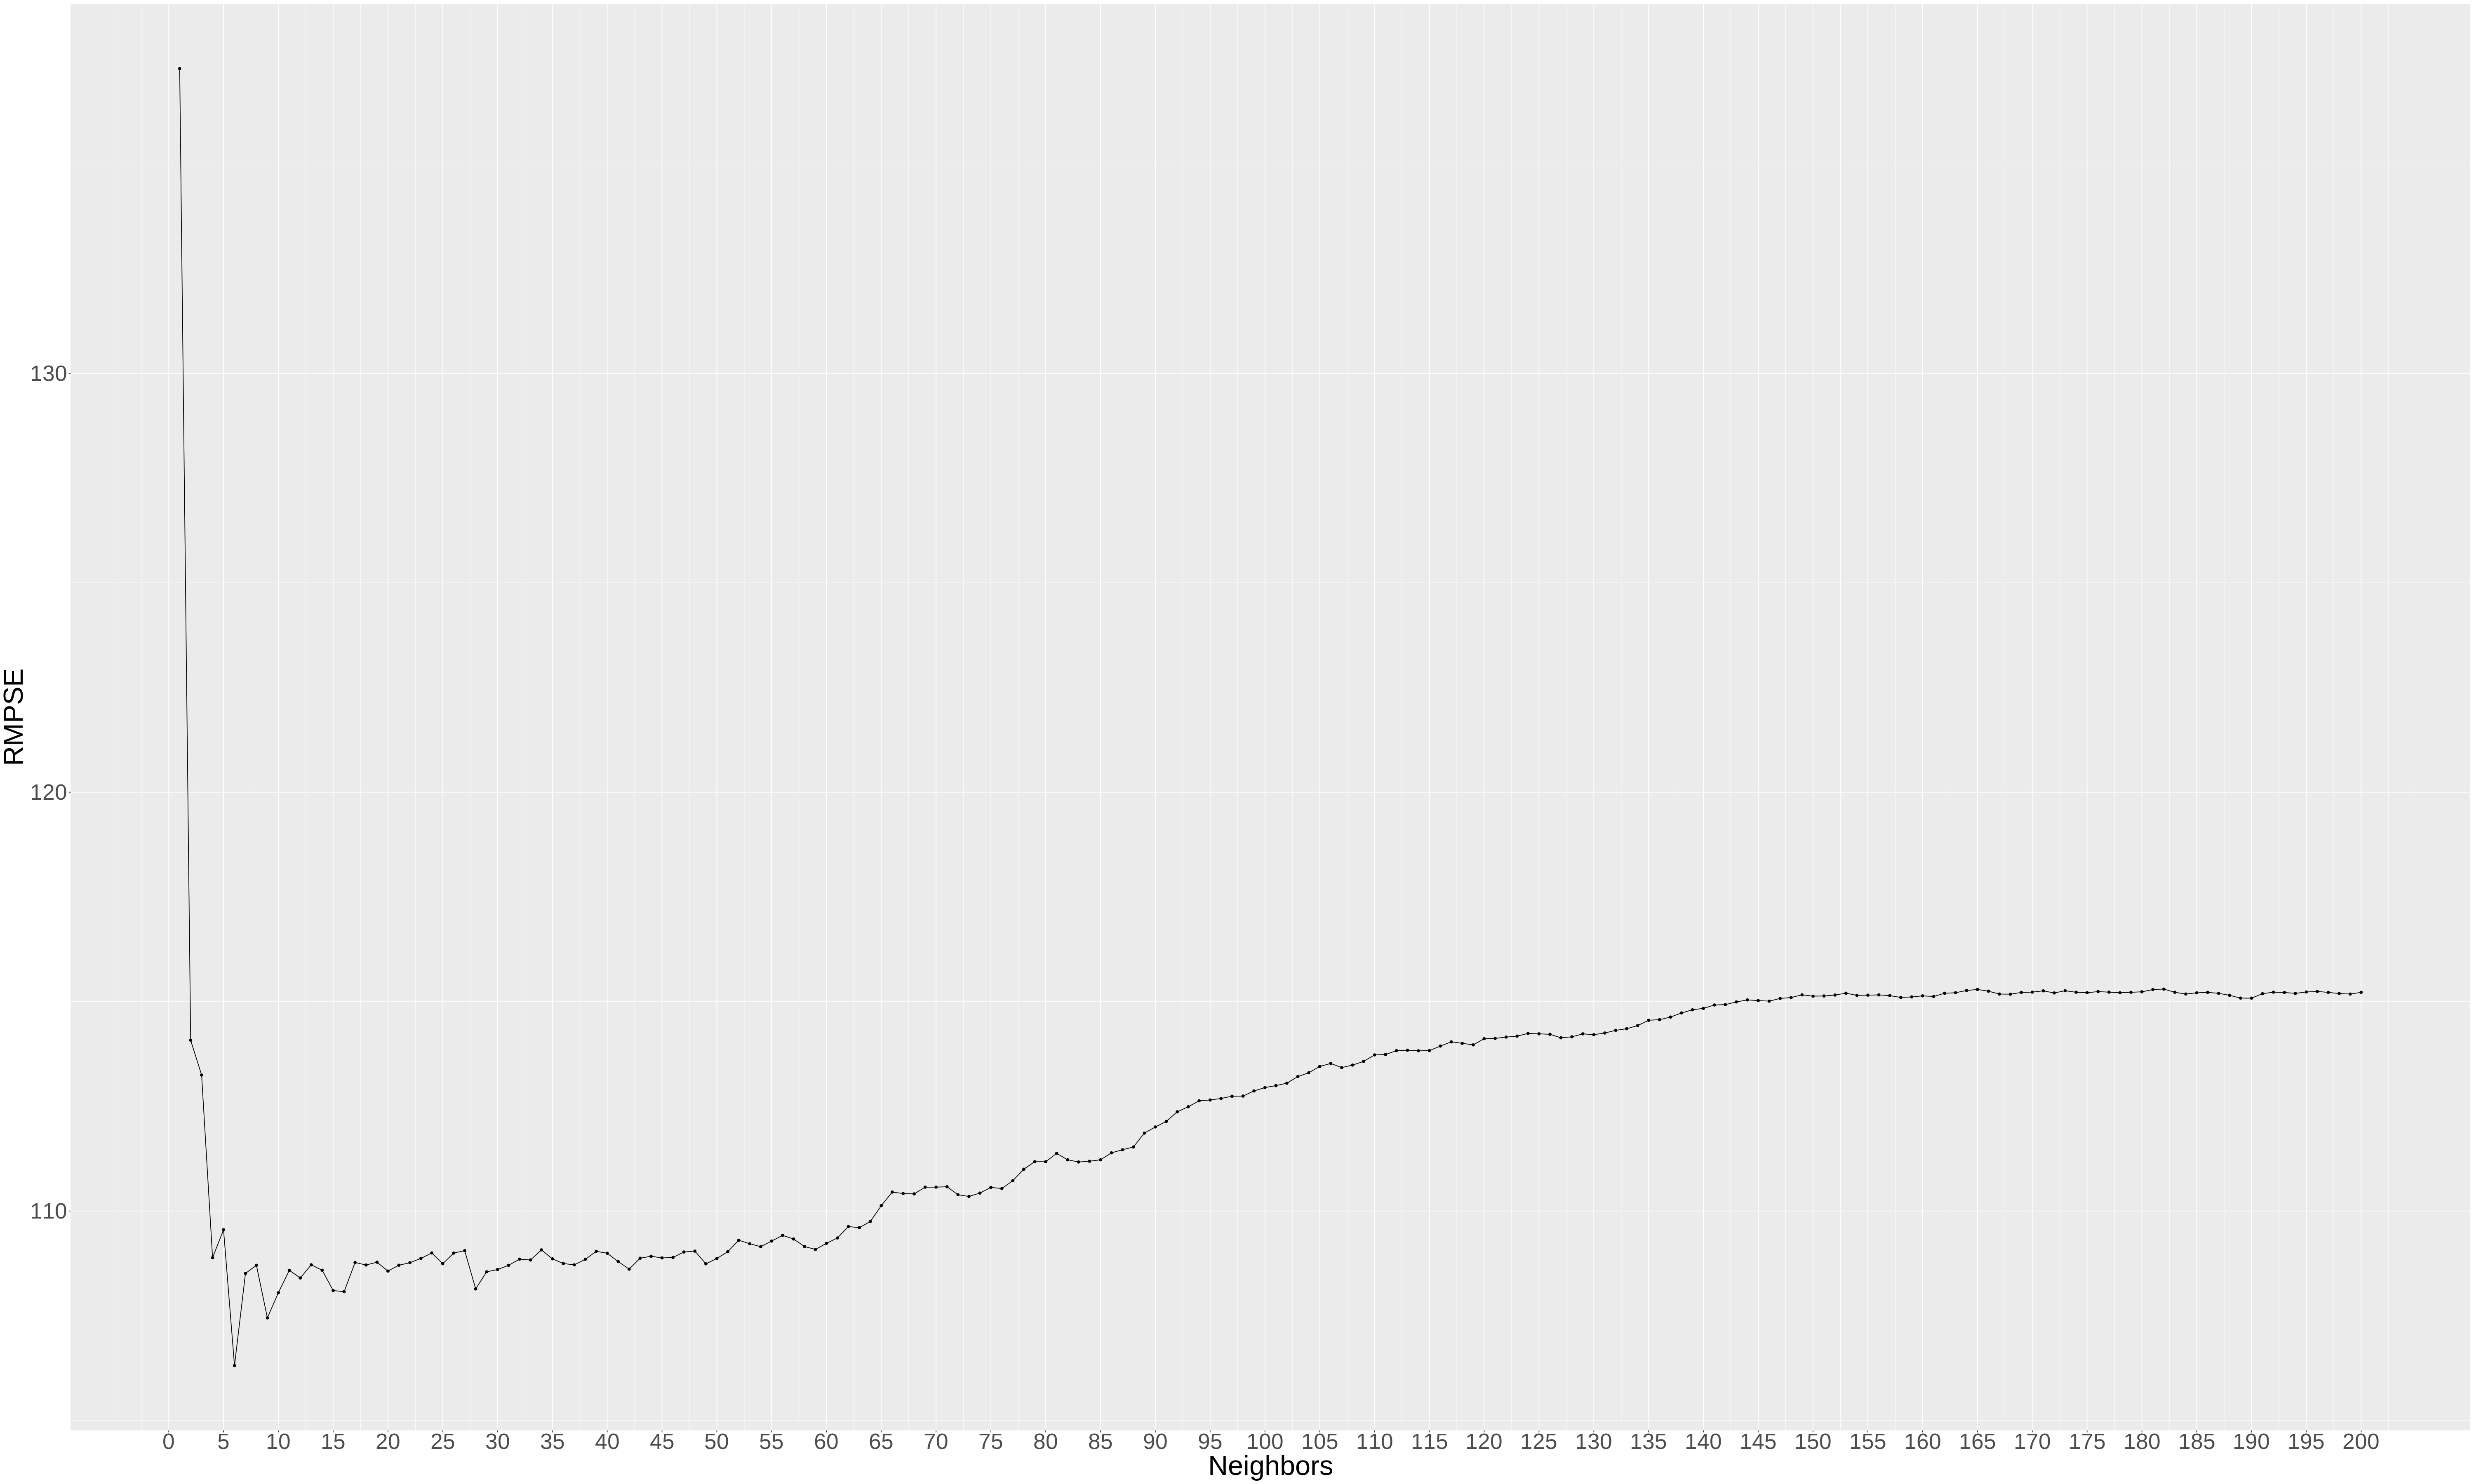

In [48]:
options(repr.plot.width = 50, repr.plot.height = 30)
cross_val_plot <- ggplot(pm2.5_multi, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "RMPSE") +
      scale_x_continuous(breaks = seq(0, 200, by = 5)) + # adjusting the y-axis
    theme(text = element_text(size=40)) +
    ggtitle("Plot of k neighbours ")
cross_val_plot

From the results, we concluded that we should choose $k = 6$ since it gave us the smallest RMSPE from our 10 fold cross validation and from the graph above we can see that if we were to increase or decrease near $k = 6$ the RMSPE does not change too much. 

In [47]:
## performing analysis with optimal K


pm2.5_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
          set_engine("kknn") %>%
          set_mode("regression")
                                    
pm2.5_fit <- workflow() %>%
        add_recipe(pm2.5_recipe) %>%
        add_model(pm2.5_best_spec) %>%
        fit(data = pm2.5_train)
                                    
pm2.5_mult_preds <- pm2.5_fit %>%
            predict(pm2.5_test) %>%
            bind_cols(pm2.5_test)
                                    
knn_mult_mets <- metrics(pm2.5_mult_preds, truth = pm2.5, estimate = .pred) %>%
            filter(.metric == "rmse")

knn_mult_mets

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,82.69519


# Discussion


## References

Liang, Xuan, et al. “Assessing Beijing’s PM 2.5 Pollution: Severity, Weather Impact, APEC and Winter Heating.” Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, vol. 471, no. 2182, Oct. 2015, https://doi.org/10.1098/rspa.2015.0257.

Wang, Jianhua, and Susumu Ogawa. “Effects of Meteorological Conditions on PM2.5 Concentrations in Nagasaki, Japan.” International Journal of Environmental Research and Public Health, vol. 12, no. 8, Aug. 2015, https://doi.org/10.3390/ijerph120809089.

Zhao, Hui, et al. “Spatiotemporal Distribution of PM2.5 and O3 and Their Interaction during the Summer and Winter Seasons in Beijing, China.” *MDPI*, Multidisciplinary Digital Publishing Institute, 30 Nov. 2018, https://www.mdpi.com/2071-1050/10/12/4519/htm. 